AAE for CIFAR10

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data as data
import torch.optim as optim
from torchvision.utils import make_grid
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [24]:
def load_pickle(path): # .pkl to numpy ndarray#
  with open(path,'rb') as f:
    data = pickle.load(f)
  train_data, test_data = data['train'], data['test']
  #print(type(train_data))
  return  train_data, test_data

https://docs.python.org/3/library/pickle.html - more information about pickle in python

In [25]:
def show_samples(samples,title,nrow = 10):
  samples = (torch.FloatTensor(samples)/255).permute(0,3,2,1) 
  # permute because in pytorch should be such consequence <batch size, image channel, image height, image width>.
  grid_img = make_grid(samples, nrow=nrow)
  plt.figure()
  plt.title(title)
  plt.imshow(grid_img.permute(1,2,0))
  plt.axis('off')
  plt.show()

In [26]:
def visualize_data(data,title):
  idxs = np.random.choice(len(data),replace=False, size = (100,))
  images = data[idxs]
  show_samples(images,title)

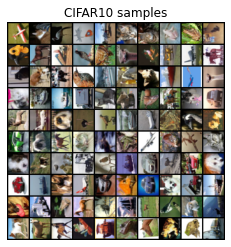

In [27]:
path = os.path.join('drive', 'My Drive','cifar10.pkl')
train_data, test_data = load_pickle(path)
visualize_data(train_data,'CIFAR10 samples')

In [46]:
transform = torchvision.transforms.Compose([transforms.ToTensor()])

In [161]:
BATCH_SIZE = 50
minimax_lr = 1e-3
reconstruction_lr = 1e-3
EPOCHS = 5
EPS =1e-15

In [162]:
data_train = torchvision.datasets.CIFAR10(root='./data',train=True,transform=transform,download =True)
data_test = torchvision.datasets.CIFAR10(root='./data',train=False,transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(dataset=data_train,batch_size = BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=BATCH_SIZE,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [56]:
next(iter(train_loader))[0].shape # one element of batch is composed of tensor[3,32,32]
next(iter(train_loader))[0][0][0] # is a tensor, whose values in [0,1]

tensor([[0.5569, 0.2196, 0.2196,  ..., 0.9608, 0.9569, 0.9686],
        [0.7216, 0.3020, 0.2863,  ..., 0.9373, 0.9529, 0.9686],
        [0.8157, 0.3843, 0.2549,  ..., 0.9569, 0.9569, 0.9490],
        ...,
        [0.4980, 0.6196, 0.7020,  ..., 0.7961, 0.7922, 0.7843],
        [0.8980, 0.8941, 0.8784,  ..., 0.7686, 0.7725, 0.7765],
        [0.8784, 0.8745, 0.8784,  ..., 0.7608, 0.7608, 0.7608]])

In [163]:
class Encoder(nn.Module):
  def __init__(self, n_latent):
    super(Encoder,self).__init__()
    self.net = nn.Sequential(
        
        nn.Conv2d(in_channels= 3, out_channels= 6, kernel_size= 4, stride = 2, padding = 1, bias= False),
        nn.BatchNorm2d(num_features = 6),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(in_channels = 6,out_channels = 12, kernel_size = 4, stride = 2,padding = 1, bias = False),
        nn.BatchNorm2d(num_features = 12),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(in_channels= 12, out_channels = 24, kernel_size = 4, stride=2, padding = 1, bias =False),
        nn.BatchNorm2d(24),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Flatten(), # From Conv2D to Linear MLP
        nn.Linear(in_features = 24*4*4, out_features= 1024),
        nn.BatchNorm1d(num_features = 1024),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.latent_layer = nn.Linear(1024, n_latent)

  # at first, will try to assump that variance distribution from normal
  # after, will not use certain distribution and will trust to neural network(encoder)
  def forward(self, input):
    output = self.net(input)
    latent_output = self.latent_layer(output)
    # 2* n_latent values in latent_output
    #mu_z, log_std_z = latent_output.chunk(2, dim=1)
    return latent_output

In [164]:
class Unflatten(nn.Module):
  def __init__(self,shape):
    super(Unflatten,self).__init__()
    self.shape = shape
  
  def forward(self, input):
    answer = input.view(len(input) , self.shape[0],self.shape[1],self.shape[2])
    return answer

In [165]:
class Decoder(nn.Module):
  
  def __init__(self,n_latent):
    super(Decoder,self).__init__()
    self.net = nn.Sequential(
        
        nn.Linear(n_latent,1024),
        nn.Linear(1024,24*4*4),
        nn.BatchNorm1d(24*4*4),
        nn.LeakyReLU(0.2, inplace = True),
        Unflatten((24,4,4)),


        
        nn.ConvTranspose2d(in_channels= 24 ,out_channels= 12 ,kernel_size = 7   ,stride = 1 ,padding = 1 ,bias=False),
        nn.BatchNorm2d(12),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(12,6, kernel_size = 4, stride = 2, padding=1, bias=False),
        nn.BatchNorm2d(6),
        nn.LeakyReLU(0.2, inplace = True),

        nn.ConvTranspose2d(6,3, kernel_size = 4, stride=2,padding=1, bias =False),
        nn.BatchNorm2d(3),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(3,3,kernel_size=3, stride = 1, padding = 1 ,bias=False),
        nn.Tanh()
    )
    
  def forward(self, input):
    return self.net(input)


In [166]:
class Discriminator(nn.Module):
  def __init__(self,n_latent):
    super(Discriminator,self).__init__()
    self.net = nn.Sequential(
        nn.Linear(n_latent,1000),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Linear(1000,1000),
        nn.LeakyReLU(0.2, inplace= True),
        nn.Linear(1000,1),
        nn.Sigmoid()

    )
  def forward(self, input):
    return self.net(input)

In [167]:
n_latent = 60
encoder = Encoder(n_latent)
decoder = Decoder(n_latent)
discriminator = Discriminator(n_latent)

In [168]:
encoder_optim = optim.Adam(encoder.parameters(),lr= reconstruction_lr)
generator_optim = optim.Adam(encoder.parameters(),lr= minimax_lr)
decoder_optim = optim.Adam(decoder.parameters(),lr= reconstruction_lr)
discriminator_optim = optim.Adam(discriminator.parameters(),lr = minimax_lr)

In [113]:
import tqdm
from tqdm import tqdm_notebook

In [138]:
# F.mse_loss in details
a = torch.tensor([ [[[2,3],[4,5]] , [[6,6],[7,9]]],  [[[10,10],[12,13]],[[14,16],[16,18]]]  ],dtype=torch.float)
b = torch.tensor([ [[[1,2],[3,4]] , [[5,6],[7,8]]],  [[[9,10],[11,12]],[[13,14],[15,16]]]  ],dtype=torch.float)
F.mse_loss(a,b,reduction='none').view(2,-1).sum(1).mean()

tensor(9.5000)

In [171]:
def train_model(num_epochs, train_loader, encoder, decoder, discriminator ):

  reconstruction_loss = []
  generator_loss = []
  discriminator_loss = []

  encoder_optim = optim.Adam(encoder.parameters(),lr= reconstruction_lr)
  generator_optim = optim.Adam(encoder.parameters(),lr= minimax_lr)
  decoder_optim = optim.Adam(decoder.parameters(),lr= reconstruction_lr)
  discriminator_optim = optim.Adam(discriminator.parameters(),lr = minimax_lr)

  for epoch in range(num_epochs):
    
    encoder.train()
    decoder.train()
    discriminator.train()

    for data,_ in tqdm_notebook(train_loader):
      
      encoder_optim.zero_grad()
      decoder_optim.zero_grad()
      discriminator_optim.zero_grad()
      generator_optim.zero_grad()

      ##### reconstruction loss #####
      latent_sample = encoder(data)
      # latent_sample.shape == torch.Size[Batch_size, n_latent = 60]
      x_sample = decoder(latent_sample)
      # x_sample.shape == torch.Size[Batch_size, 3, 32,32]
      # data.shape == torch.Size([Batch_size, 3, 32, 32])
      

      recon_loss = F.mse_loss(x_sample,data,reduction='none')
      # recon_loss.shape == torch.Size([Batch_size,3,32,32])
      recon_loss = recon_loss.view(BATCH_SIZE,-1).sum(1).mean()
      reconstruction_loss.append(recon_loss.item())
      
      recon_loss.backward()
      encoder_optim.step()
      decoder_optim.step()


      #### discriminator loss   #####

      encoder.eval()
      real_latent = torch.randn(BATCH_SIZE,n_latent)
      # real_latent.shape == torch.Size([BATCH_SIZE,n_latent])
      real_discriminator = discriminator(real_latent)
      # real_discriminator.shape == torch.Size([Batch_Size,1])

      fake_latent = encoder(data)
      fake_discriminator = discriminator(fake_latent)
      #fake_discriminator.shape == torch.Size([Batch_size,1])
      
      discr_loss = -torch.mean(torch.log(real_discriminator + EPS) + torch.log( 1 - fake_discriminator + EPS))
      discriminator_loss.append(discr_loss)
      discr_loss.backward()
      discriminator_optim.step()
      

      ####   generator   loss   ####
      encoder.train()

      fake_latent = encoder(data)
      fake_discriminator = discriminator(fake_latent)

      gen_loss = -torch.mean(torch.log(fake_discriminator + EPS))
      generator_loss.append(gen_loss)
      gen_loss.backward()
      generator_optim.step()
      


  return reconstruction_loss, discriminator_loss, generator_loss

In [173]:
reconstruction_loss, discriminator_loss, generator_loss =   train_model(EPOCHS,train_loader,encoder, decoder, discriminator )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


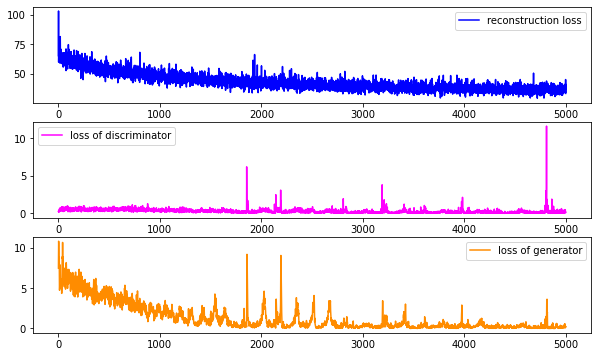

In [174]:
fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(reconstruction_loss, color = 'blue', label = 'reconstruction loss')
ax[1].plot(discriminator_loss,color='magenta', label = 'loss of discriminator')
ax[2].plot(generator_loss,color='darkorange', label = 'loss of generator')
ax[1].legend()
ax[0].legend()
ax[2].legend()
plt.show()

https://github.com/artemsavkin/aae/blob/master/aae.ipynb